### Importing the necessary libraries

In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import os
import cv2
import random
import sklearn.model_selection as model_selection

In [2]:
categories = ["NonDemented", "MildDemented", "ModerateDemented", "VeryMildDemented"]

SIZE = 120

### Loading the data into memory

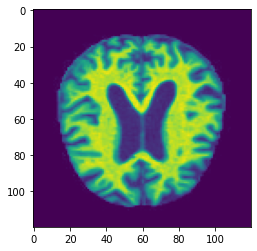

In [3]:
img = cv2.imread('./data/MildDemented/26 (19).jpg', cv2.IMREAD_GRAYSCALE)
new_img = cv2.resize(img, (SIZE, SIZE))
plt.imshow(new_img)

In [4]:
def getData():
    rawdata = []
    data = []
    dir = "./data"
    for category in categories:
        path = os.path.join(dir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                rawdata = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                new_data = cv2.resize(rawdata, (SIZE, SIZE))

                data.append([new_data, class_num])
            except Exception as e:
                pass
    
    random.seed(42)
    random.shuffle(data)

    img_data = []
    img_labels = []
    for features, label in data:
        img_data.append(features)
        img_labels.append(label)
    img_data = np.array(img_data).reshape(-1, SIZE, SIZE, 1)
    img_data = img_data / 255.0
    img_labels = np.array(img_labels)

    return img_data, img_labels

In [5]:
data, labels = getData()

In [6]:
data.shape

(6399, 120, 120, 1)

### Visualizing the data

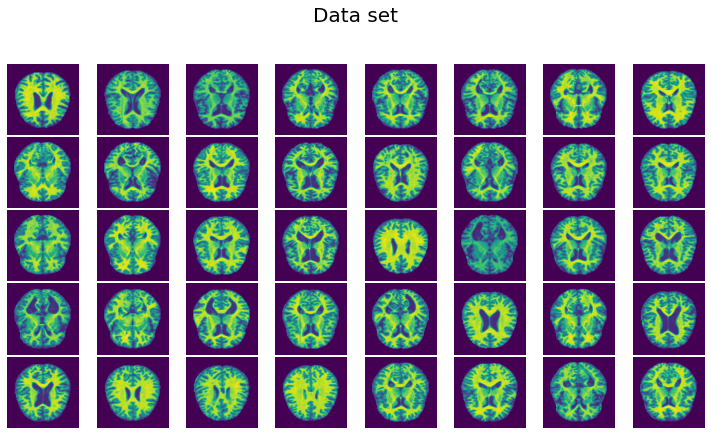

In [7]:
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = figsize, facecolor = (1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize = 20)
    plt.tight_layout(pad = 0.2, rect = [0, 0, 1, 0.9])
    plt.show()
    
plot_images(data, 'Data set')

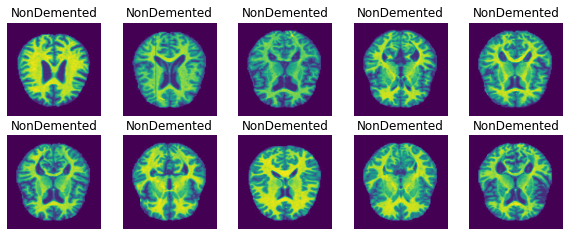

In [11]:
def show_images(images, labels):
  plt.figure(figsize=(10,10))
  for i in range(10):
    ax = plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.title(categories[labels[i].argmax()])
    plt.axis("off")
  
show_images(data, labels)

### Splitting the data into training, validation and test set

In [12]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(data, labels, test_size=0.20)

train_data, val_data, train_labels, val_labels = model_selection.train_test_split(train_data, train_labels,test_size=0.10)

In [13]:
train_data.shape, test_data.shape, val_data.shape

((4607, 120, 120, 1), (1280, 120, 120, 1), (512, 120, 120, 1))

In [14]:
train_labels.shape, test_labels.shape, val_labels.shape

((4607,), (1280,), (512,))

### Building the CNN Model

In [15]:
class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_accuracy') > .95:
      print("\nReached Validation Accuracy of", logs.get('val_accuracy'))
      self.model.stop_training = True

callbacks = MyCallback()

#### Model 1

In [74]:
model_1 = tf.keras.Sequential([
      tf.keras.layers.InputLayer(input_shape = train_data.shape[1:]),
      tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, activation = 'relu'),
      tf.keras.layers.MaxPooling2D(2),
      tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu'),
      tf.keras.layers.MaxPooling2D(2),
      tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu'),
      tf.keras.layers.MaxPooling2D(2),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(1024, activation='relu'),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dropout(.5),
      tf.keras.layers.Dense(4, activation='softmax')
])

model_1.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 118, 118, 16)      160       
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 59, 59, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_53 (Conv2D)          (None, 57, 57, 32)        4640      
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 28, 28, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_54 (Conv2D)          (None, 26, 26, 32)        9248      
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 13, 13, 32)     

In [56]:
model_1.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model_1.fit(train_data, train_labels, epochs = 20, validation_data = (val_data, val_labels), callbacks=[callbacks])

Epoch 1/20
144/144 [==============================] - 49s 330ms/step - loss: 1.2225 - accuracy: 0.5014 - val_loss: 1.1302 - val_accuracy: 0.3516
Epoch 2/20
144/144 [==============================] - 47s 327ms/step - loss: 0.9449 - accuracy: 0.5229 - val_loss: 1.1936 - val_accuracy: 0.2520
Epoch 3/20
144/144 [==============================] - 58s 401ms/step - loss: 0.9168 - accuracy: 0.5466 - val_loss: 1.5536 - val_accuracy: 0.3516
Epoch 4/20
144/144 [==============================] - 50s 347ms/step - loss: 0.8810 - accuracy: 0.5672 - val_loss: 1.4547 - val_accuracy: 0.3711
Epoch 5/20
144/144 [==============================] - 53s 365ms/step - loss: 0.8221 - accuracy: 0.6099 - val_loss: 1.0734 - val_accuracy: 0.4863
Epoch 6/20
144/144 [==============================] - ETA: 0s - loss: 0.7214 - accuracy: 0.6690

KeyboardInterrupt: 

#### Model 2

In [83]:
model_2 = tf.keras.Sequential([
      tf.keras.layers.InputLayer(input_shape = train_data.shape[1:]),
      tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, activation = 'relu'),
      tf.keras.layers.MaxPooling2D(2),
      tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu'),
      tf.keras.layers.MaxPooling2D(2),
      tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu'),
      tf.keras.layers.MaxPooling2D(2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dropout(.5),
      tf.keras.layers.Dense(4, activation='softmax')
])

model_2.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_66 (Conv2D)          (None, 118, 118, 16)      160       
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 59, 59, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_67 (Conv2D)          (None, 57, 57, 32)        4640      
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 28, 28, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_68 (Conv2D)          (None, 26, 26, 32)        9248      
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 13, 13, 32)     

In [84]:
model_2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

his = model_2.fit(train_data, train_labels, epochs = 20, validation_data = (val_data, val_labels), callbacks=[callbacks])

Epoch 1/20
144/144 [==============================] - 34s 224ms/step - loss: 1.0099 - accuracy: 0.5079 - val_loss: 0.9162 - val_accuracy: 0.5996
Epoch 2/20
144/144 [==============================] - 33s 230ms/step - loss: 0.9087 - accuracy: 0.5763 - val_loss: 0.8648 - val_accuracy: 0.5977
Epoch 3/20
144/144 [==============================] - 33s 229ms/step - loss: 0.8226 - accuracy: 0.6249 - val_loss: 0.7961 - val_accuracy: 0.6133
Epoch 4/20
144/144 [==============================] - 34s 235ms/step - loss: 0.7018 - accuracy: 0.6872 - val_loss: 0.6720 - val_accuracy: 0.6758
Epoch 5/20
144/144 [==============================] - 33s 231ms/step - loss: 0.5438 - accuracy: 0.7758 - val_loss: 0.5521 - val_accuracy: 0.7598
Epoch 6/20
144/144 [==============================] - 35s 240ms/step - loss: 0.4049 - accuracy: 0.8357 - val_loss: 0.3774 - val_accuracy: 0.8594
Epoch 7/20
144/144 [==============================] - 32s 220ms/step - loss: 0.2736 - accuracy: 0.8973 - val_loss: 0.3069 - val_ac

#### Model 3

In [77]:
model_3 = tf.keras.Sequential([
      tf.keras.layers.InputLayer(input_shape = train_data.shape[1:]),
      tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, activation = 'relu'),
      tf.keras.layers.MaxPooling2D(2),
      tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu'),
      tf.keras.layers.MaxPooling2D(2),
      tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu'),
      #tf.keras.layers.MaxPooling2D(2),
      tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu'),
      tf.keras.layers.MaxPooling2D(2),
      tf.keras.layers.Flatten(),
      #tf.keras.layers.Dense(1024, activation = 'relu'),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dropout(.5),
      tf.keras.layers.Dense(4, activation='softmax')
])

model_3.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_59 (Conv2D)          (None, 118, 118, 16)      160       
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 59, 59, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_60 (Conv2D)          (None, 57, 57, 32)        4640      
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 28, 28, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_61 (Conv2D)          (None, 26, 26, 64)        18496     
                                                                 
 conv2d_62 (Conv2D)          (None, 24, 24, 64)      

In [78]:
model_3.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model_3.fit(train_data, train_labels, epochs = 20, validation_data = (val_data, val_labels), callbacks=[callbacks])

Epoch 1/20
144/144 [==============================] - 42s 291ms/step - loss: 1.0353 - accuracy: 0.4966 - val_loss: 0.9503 - val_accuracy: 0.5156
Epoch 2/20
144/144 [==============================] - 43s 299ms/step - loss: 0.8985 - accuracy: 0.5774 - val_loss: 0.8825 - val_accuracy: 0.6113
Epoch 3/20
144/144 [==============================] - 42s 291ms/step - loss: 0.8111 - accuracy: 0.6410 - val_loss: 0.7986 - val_accuracy: 0.6055
Epoch 4/20
144/144 [==============================] - 43s 295ms/step - loss: 0.6764 - accuracy: 0.6979 - val_loss: 0.6479 - val_accuracy: 0.7109
Epoch 5/20
144/144 [==============================] - 42s 293ms/step - loss: 0.5259 - accuracy: 0.7827 - val_loss: 0.4578 - val_accuracy: 0.8086
Epoch 6/20
144/144 [==============================] - 42s 293ms/step - loss: 0.3613 - accuracy: 0.8513 - val_loss: 0.3412 - val_accuracy: 0.8672
Epoch 7/20
144/144 [==============================] - 42s 292ms/step - loss: 0.2208 - accuracy: 0.9255 - val_loss: 0.2679 - val_ac

### Evaluate

In [85]:
model_2.evaluate(test_data, test_labels)

40/40 [==============================] - 2s 46ms/step - loss: 0.1067 - accuracy: 0.9617


[0.10671569406986237, 0.961718738079071]

In [86]:
model_3.evaluate(test_data, test_labels)

40/40 [==============================] - 2s 56ms/step - loss: 0.1111 - accuracy: 0.9578


[0.11114971339702606, 0.957812488079071]

### Save the Model

In [87]:
model_2.save('E:\Major Project\Project Implementation\model\model_2.h5')

model_3.save('E:\Major Project\Project Implementation\model\model_3.h5')

### Plotting the Accuracy and Loss graph

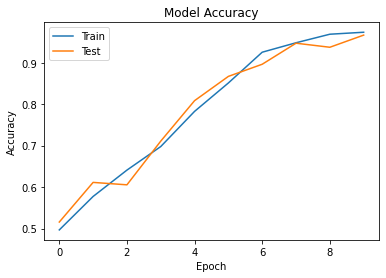

In [81]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

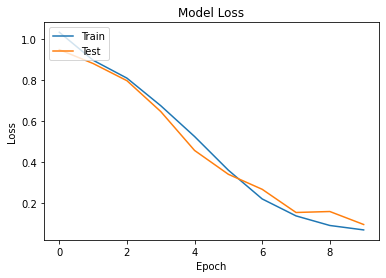

In [82]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Feature Map

In [88]:
img_path='./data/MildDemented/mildDem693.jpg'

successive_outputs = [layer.output for layer in model_2.layers[1:]]

visualization_model = tf.keras.models.Model(inputs = model_2.input, outputs = successive_outputs)
img = tf.keras.utils.load_img(img_path, target_size=(120, 120), color_mode='grayscale')
x = tf.keras.utils.img_to_array(img)                           
x = x.reshape((1,) + x.shape)
x /= 255.0

In [89]:
successive_feature_maps = visualization_model.predict(x)

layer_names = [layer.name for layer in model_2.layers]

In [90]:
layer_names

['conv2d_66',
 'max_pooling2d_51',
 'conv2d_67',
 'max_pooling2d_52',
 'conv2d_68',
 'max_pooling2d_53',
 'flatten_16',
 'dense_39',
 'dropout_11',
 'dense_40']

(1, 59, 59, 16)
(1, 57, 57, 32)
(1, 28, 28, 32)
(1, 26, 26, 32)
(1, 13, 13, 32)
(1, 5408)
(1, 512)
(1, 512)
(1, 4)


C:\Python37\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


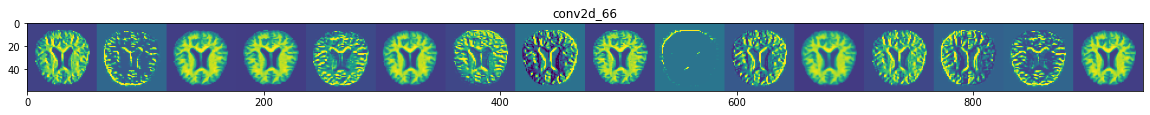

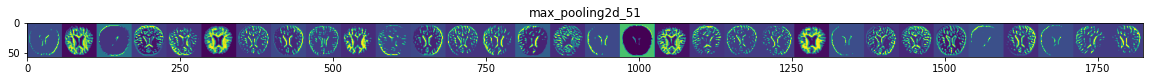

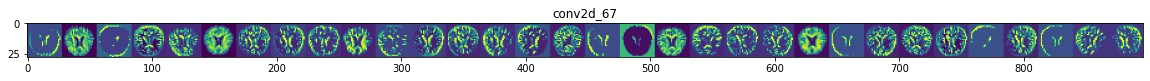

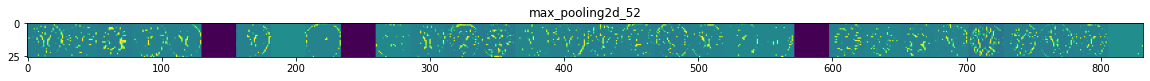

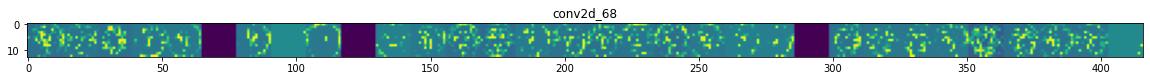

In [91]:
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    n_features = feature_map.shape[-1]
    size = feature_map.shape[ 1]
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x
    scale = 20. / n_features
    plt.figure(figsize = (scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')